# Stable Diffusion Pipeline

## Setup and Imports

In [1]:
!pip install --upgrade --quiet diffusers transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.5 MB/s eta 0:00:00


In [2]:
import torch

from diffusers import (AutoencoderKL, StableDiffusionPipeline,
                       UNet2DConditionModel)
from PIL import Image
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Quick Example of the Completed Pipeline

Following the example found [here](https://huggingface.co/CompVis/stable-diffusion-v1-4#pytorch), generating an image can be as simple as calling the pipeline with the desired prompt.

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

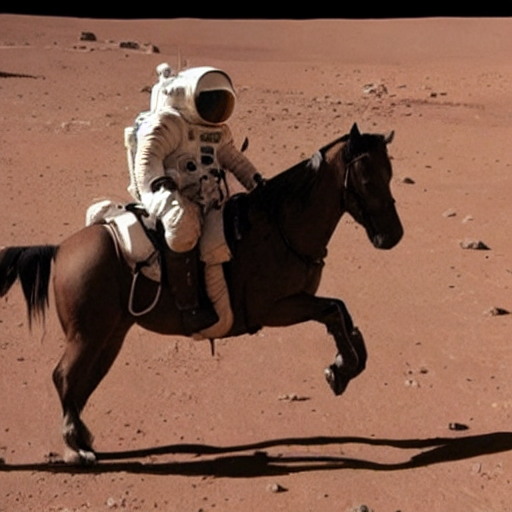

In [3]:
torch.manual_seed(1337)

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                               torch_dtype=torch.float16)
pipe = pipe.to(device)

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")
image

## Implementing the Pipeline

The goal of this notebook is to implement each component of the stable diffusion pipeline and dive deeper into each one as I progress through the [Practical Deep Learning for Coders: Part 2](https://course.fast.ai/Lessons/part2.html) course.

I will be checking mostly the [Hugging Face docs](https://huggingface.co/docs) and the source code of each individual module, such as [the source code for the pipeline itself](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py).

TODO: Diagram of the stable diffusion pipeline.

Here are the parameters used for the generation of each image.

In [4]:
height = 512
width = 512
guidance_scale = 7.5
batch_size = 1

### Text Encoder

This component will take our prompt and turn it into valid inputs for the stable diffusion model. As output we will get an embedding of our desired prompt and an embedding of the unconditional prompt to be used in Classifier-Free Guidance later.

In [5]:
def print_shape(tensor):
  print('Shape: ', tensor.shape)

[from_pretrained()](https://huggingface.co/docs/transformers/v4.42.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.from_pretrained)

[tokenizer()](https://huggingface.co/docs/transformers/v4.42.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__)

In [6]:
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14',
                                          torch_dtype=torch.float16)
text_inputs = tokenizer(text=prompt, padding='max_length', truncation=True,
                        max_length=tokenizer.model_max_length,
                        return_tensors='pt')
tokenized_prompt = text_inputs.input_ids
print_shape(tokenized_prompt)
print(tokenized_prompt)

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Shape:  torch.Size([1, 77])
tensor([[49406,   320,  1125,   539,   550, 18376,  6765,   320,  4558,   525,
          7496, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])


Above we have our tokenised prompt. We take each word from our prompt and map it to a number (token). Note that we pad our prompt to be the correct size that the model expects, which is 77.

We can decode the tokenised prompt to get our prompt back.

[decode()](https://huggingface.co/docs/transformers/v4.42.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.decode)

In [7]:
print('input: ', prompt)
print('encoded output: ', tokenized_prompt)
print('decoded output: ', end='')
for id in tokenized_prompt:
  print(tokenizer.decode(id))

input:  a photo of an astronaut riding a horse on mars
encoded output:  tensor([[49406,   320,  1125,   539,   550, 18376,  6765,   320,  4558,   525,
          7496, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])
decoded output: <|startoftext|>a photo of an astronaut riding a horse on mars <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e

In [8]:
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14',
                                             torch_dtype=torch.float16).to(device)
# text_encoder.config # Advanced information of the text model

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

[text_encoder()](https://huggingface.co/docs/transformers/en/model_doc/clip#transformers.CLIPTextModel.forward)

In [9]:
prompt_embeddings = text_encoder(tokenized_prompt.to(device=device))
prompt_embeddings = prompt_embeddings[0].to(dtype=torch.float16, device=device)
print_shape(prompt_embeddings)
print(prompt_embeddings)

Shape:  torch.Size([1, 77, 768])
tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.0292, -1.3242,  0.3076,  ..., -0.5254,  0.9766,  0.6655],
         [ 1.1562,  0.1326,  0.7881,  ..., -2.1035, -1.1494, -0.3308],
         ...,
         [-2.2578,  0.5669, -0.2500,  ..., -0.4861,  0.0545,  0.6318],
         [-2.2637,  0.5679, -0.2729,  ..., -0.4805,  0.0518,  0.6143],
         [-2.2246,  0.5786, -0.2722,  ..., -0.4226,  0.0718,  0.5952]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)


This is the embedding of our prompt required for the stable diffusion model. We mapped our tokens to a higher dimensional space, so for each token we get a tensor that is 768 elements long.

We can now define a function that automates the generation of the embeddings for any given prompt.

In [10]:
def prompt_to_embedding(prompt, tokenizer, text_encoder):
  text_inputs = tokenizer(text=prompt, padding='max_length', truncation=True,
                          max_length=tokenizer.model_max_length,
                          return_tensors='pt')
  tokenized_prompt = text_inputs.input_ids
  prompt_embeddings = text_encoder(tokenized_prompt.to(device))

  return prompt_embeddings[0].to(dtype=torch.float16, device=device)

Let's check if the unconditional prompt is mapped to a different embedding than our prompt.

In [11]:
unconditional_prompt = ''
unconditional_prompt_embeddings = prompt_to_embedding(unconditional_prompt, tokenizer, text_encoder)
print_shape(unconditional_prompt_embeddings)
print(unconditional_prompt_embeddings)

Shape:  torch.Size([1, 77, 768])
tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [-0.3718, -1.4502, -0.3403,  ...,  0.9492,  0.1862, -1.1016],
         [-0.5112, -1.4619, -0.2927,  ...,  1.0410,  0.0698, -1.0283],
         ...,
         [ 0.4998, -0.9565, -0.6621,  ...,  1.6006, -1.0625, -0.2192],
         [ 0.4983, -0.9473, -0.6631,  ...,  1.6475, -1.0859, -0.2098],
         [ 0.4919, -0.8145, -0.4919,  ...,  1.6104, -1.0176, -0.2484]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)


It is! Now we can define a function to get the inputs the model expects from our prompt.

In [12]:
def encode_prompt(prompt, tokenizer, text_encoder):
  prompt_embeddings = prompt_to_embedding(prompt, tokenizer, text_encoder)
  unconditional_embeddings = prompt_to_embedding('', tokenizer, text_encoder)

  return prompt_embeddings, unconditional_embeddings

encode_prompt(prompt, tokenizer, text_encoder)

(tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
          [ 0.0292, -1.3242,  0.3076,  ..., -0.5254,  0.9766,  0.6655],
          [ 1.1562,  0.1326,  0.7881,  ..., -2.1035, -1.1494, -0.3308],
          ...,
          [-2.2578,  0.5669, -0.2500,  ..., -0.4861,  0.0545,  0.6318],
          [-2.2637,  0.5679, -0.2729,  ..., -0.4805,  0.0518,  0.6143],
          [-2.2246,  0.5786, -0.2722,  ..., -0.4226,  0.0718,  0.5952]]],
        device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>),
 tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
          [-0.3718, -1.4502, -0.3403,  ...,  0.9492,  0.1862, -1.1016],
          [-0.5112, -1.4619, -0.2927,  ...,  1.0410,  0.0698, -1.0283],
          ...,
          [ 0.4998, -0.9565, -0.6621,  ...,  1.6006, -1.0625, -0.2192],
          [ 0.4983, -0.9473, -0.6631,  ...,  1.6475, -1.0859, -0.2098],
          [ 0.4919, -0.8145, -0.4919,  ...,  1.6104, -1.0176, -0.2484]]],
        device='cud

### The Rest

In [13]:
vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-ema', torch_dtype=torch.float16, low_cpu_mem_usage=False).to('cuda')
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='unet', torch_dtype=torch.float16, low_cpu_mem_usage=False).to('cuda')

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [14]:
torch.manual_seed(1337)
latents = torch.randn((batch_size, unet.config.in_channels, height//8, width//8))
latents = latents.to('cuda').half()
latents.shape

torch.Size([1, 4, 64, 64])

In [15]:
from diffusers import LMSDiscreteScheduler

In [16]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')

In [17]:
num_inference_steps = 50

In [18]:
scheduler.set_timesteps(num_inference_steps)

In [19]:
latents = latents * scheduler.init_noise_sigma

In [20]:
import matplotlib.pyplot as plt

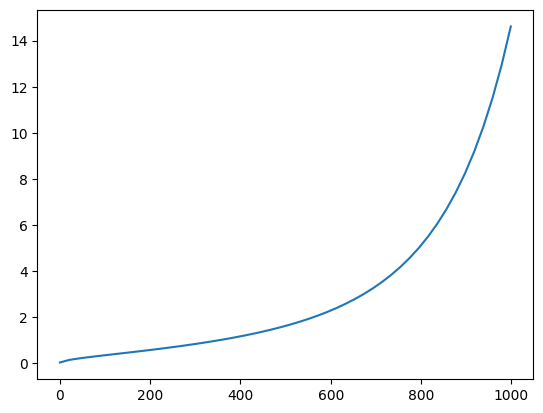

In [21]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1])

In [22]:
prompt_embeddings, unconditional_prompt_embeddings = encode_prompt(prompt, tokenizer, text_encoder)
text_embeddings = torch.cat([unconditional_prompt_embeddings, prompt_embeddings])

In [23]:
for i, t in enumerate(tqdm(scheduler.timesteps)):
  input = torch.cat([latents] * 2)
  input = scheduler.scale_model_input(input, t)

  with torch.no_grad():
    pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

  pred_uncond, pred_text = pred.chunk(2)
  pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

  latents = scheduler.step(pred, t, latents).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

In [24]:
with torch.no_grad():
  image = vae.decode(1/.18215 * latents).sample

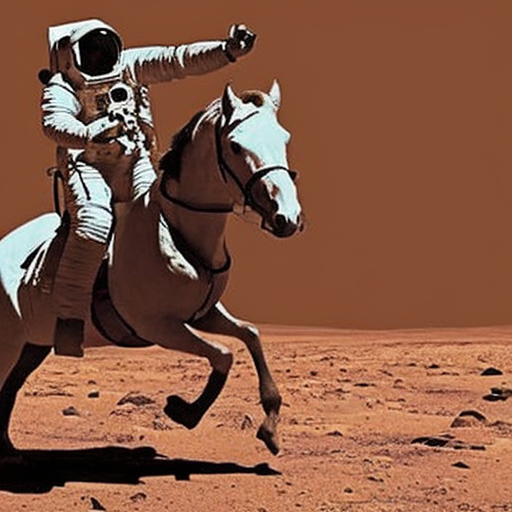

In [25]:
image = (image/2+.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image*255).round().astype('uint8')
Image.fromarray(image)